In [1]:
import matplotlib.pyplot as plt
import numpy as np
import mysg # Tom Robitaille's YSO grid tool
from astropy.table import Table

from astropy.io import fits
from astropy import units as u, constants
import pylab as pl
import requests

from icemodels import absorbed_spectrum, absorbed_spectrum_Gaussians, convsum, fluxes_in_filters, load_molecule, atmo_model, molecule_data
del molecule_data['h2o_b']

from astropy.visualization import simple_norm


In [2]:
cd ../smart-plotters

/blue/adamginsburg/savannahgramze/cloudc/smart-plotters/smart-plotters


In [3]:
from jwst_plots import JWSTCatalog, make_cat_use
from glimpse_plots import GlimpseCatalog
from cutout_plot import Cutout

In [4]:
cd ../notebooks

/blue/adamginsburg/savannahgramze/cloudc/smart-plotters/notebooks


In [5]:
import dust_extinction
from dust_extinction.averages import RRP89_MWGC, CT06_MWGC, F11_MWGC, G21_MWAvg
from dust_extinction.parameter_averages import CCM89
from astroquery.svo_fps import SvoFps


# Filter Abs

In [ ]:
jfilts = SvoFps.get_filter_list('JWST')
jfilts.add_index('filterID')

In [ ]:
instrument = 'NIRCam'
telescope = 'JWST'
filt466 = 'F466N'
#filt470 = 'F470N'
wavelength_table_466 = SvoFps.get_transmission_data(f'{telescope}/{instrument}.{filt466}')
#wavelength_table_470 = SvoFps.get_transmission_data(f'{telescope}/{instrument}.{filt470}')
wavelength_table_410 = SvoFps.get_transmission_data(f'{telescope}/{instrument}.F410M')
wavelength_table_405 = SvoFps.get_transmission_data(f'{telescope}/{instrument}.F405N')

wavelength_tables_jwst = {filt: SvoFps.get_transmission_data(f'{telescope}/{instrument}.{filt}')
                          for filt in ['F466N', 'F410M', 'F405N']}

Text(0, 0.5, 'Transmission')

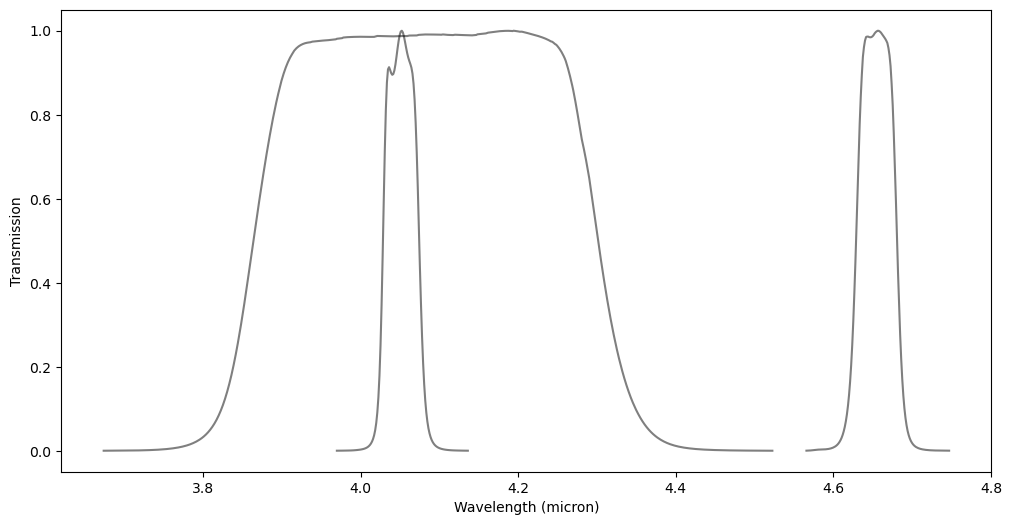

In [ ]:
fig = plt.figure(figsize=(12, 6))

for filt, tbl in wavelength_tables_jwst.items():
    xarr = tbl['Wavelength'].quantity.to(u.micron)
    plt.plot(xarr, tbl['Transmission']/tbl['Transmission'].max(), color='k', alpha=0.5, label=filt)

plt.xlabel('Wavelength (micron)')
plt.ylabel('Transmission')

In [ ]:
instrument = 'IRAC'
telescope = 'Spitzer'
wavelength_tables_spitzer = {filt: SvoFps.get_transmission_data(f'{telescope}/{instrument}.{filt}')
                             for filt in ['I1', 'I2', 'I3', 'I4']}

wavelength_tables = {#'f470n': wavelength_table_470,
                     'f466n': wavelength_table_466,
                     'f410m': wavelength_table_410,
                     'f405n': wavelength_table_405,
                    }
wavelength_tables.update(wavelength_tables_spitzer)

Text(0, 0.5, 'Transmission')

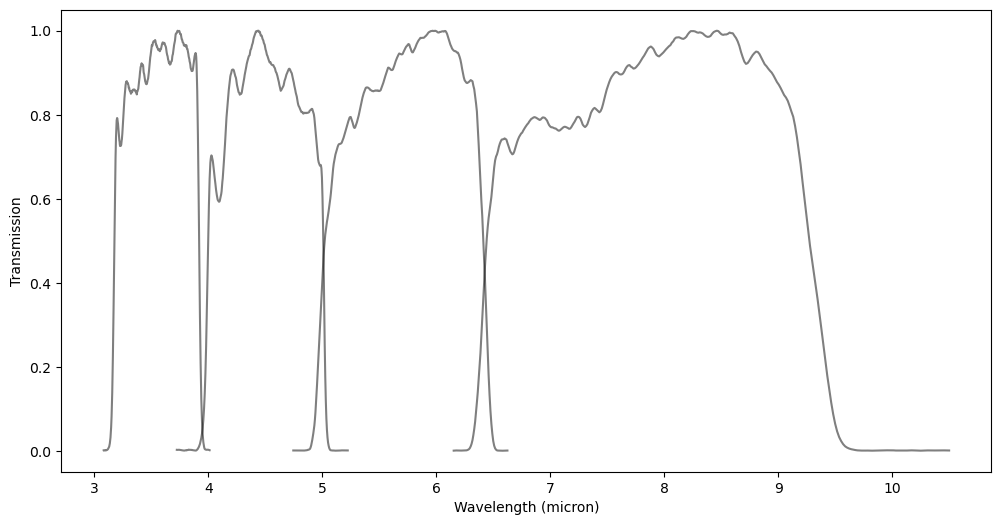

In [ ]:
fig = plt.figure(figsize=(12, 6))

for filt, tbl in wavelength_tables_spitzer.items():
    xarr = tbl['Wavelength'].quantity.to(u.micron)
    plt.plot(xarr, tbl['Transmission']/tbl['Transmission'].max(), color='k', alpha=0.5, label=filt)

plt.xlabel('Wavelength (micron)')
plt.ylabel('Transmission')

In [ ]:
instrument = 'WISE'
telescope = 'WISE'
wavelength_tables_wise = {filt: SvoFps.get_transmission_data(f'{telescope}/{instrument}.{filt}')
                          for filt in ['W1', 'W2', 'W3', 'W4']}

Text(0, 0.5, 'Transmission')

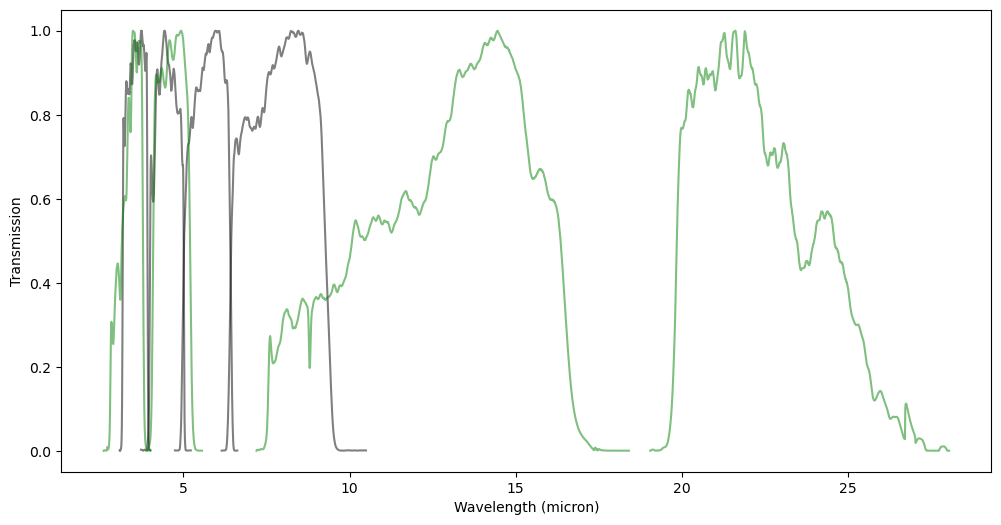

In [ ]:
fig = plt.figure(figsize=(12, 6))

#for filt, tbl in wavelength_tables_jwst.items():
#    xarr = tbl['Wavelength'].quantity.to(u.micron)
#    plt.plot(xarr, tbl['Transmission']/tbl['Transmission'].max(), color='k', alpha=0.5, label=filt)

for filt, tbl in wavelength_tables_spitzer.items():
    xarr = tbl['Wavelength'].quantity.to(u.micron)
    plt.plot(xarr, tbl['Transmission']/tbl['Transmission'].max(), color='k', alpha=0.5, label=filt)

for filt, tbl in wavelength_tables_wise.items():
    xarr = tbl['Wavelength'].quantity.to(u.micron)
    plt.plot(xarr, tbl['Transmission']/tbl['Transmission'].max(), color='g', alpha=0.5, label=filt)

plt.xlabel('Wavelength (micron)')
plt.ylabel('Transmission')

Text(0, 0.5, 'Transmission')

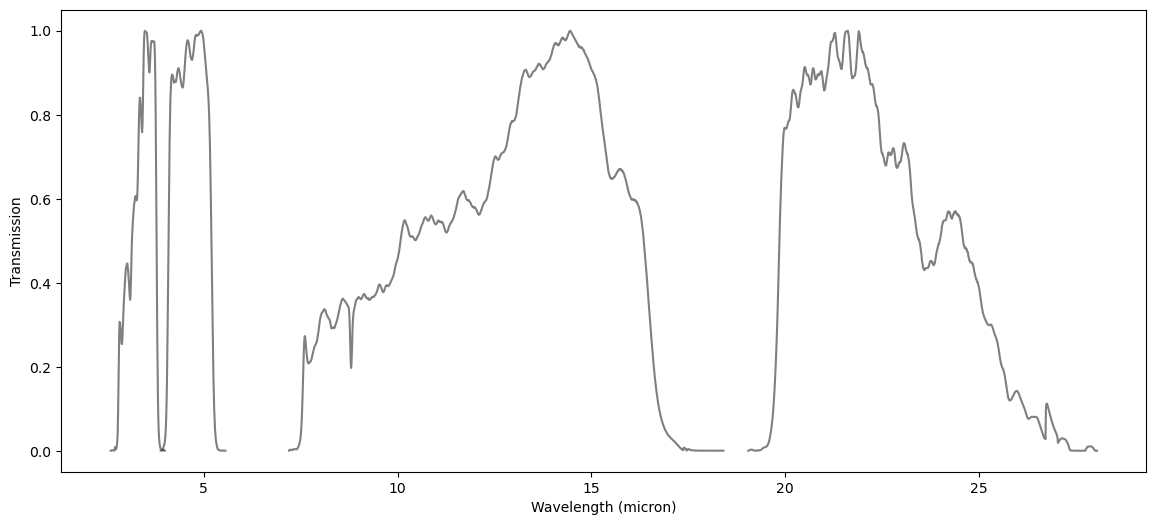

In [ ]:
fig = plt.figure(figsize=(14, 6))

for filt, tbl in wavelength_tables_wise.items():
    xarr = tbl['Wavelength'].quantity.to(u.micron)
    plt.plot(xarr, tbl['Transmission']/tbl['Transmission'].max(), color='k', alpha=0.5, label=filt)

plt.xlabel('Wavelength (micron)')
plt.ylabel('Transmission')

In [ ]:
instrument = '2MASS'
telescope = '2MASS'
wavelength_tables_2mass = {filt: SvoFps.get_transmission_data(f'{telescope}/{instrument}.{filt}')
                          for filt in ['J', 'H', 'Ks']}

Text(0, 0.5, 'Transmission')

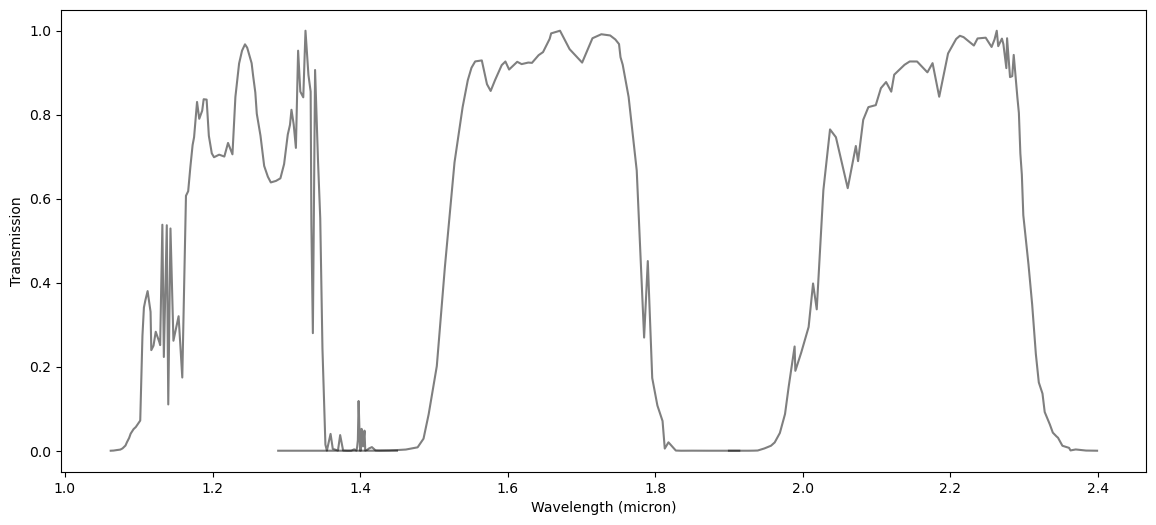

In [ ]:
fig = plt.figure(figsize=(14, 6))

for filt, tbl in wavelength_tables_2mass.items():
    xarr = tbl['Wavelength'].quantity.to(u.micron)
    plt.plot(xarr, tbl['Transmission']/tbl['Transmission'].max(), color='k', alpha=0.5, label=filt)

plt.xlabel('Wavelength (micron)')
plt.ylabel('Transmission')

# Ice Absorption

In [ ]:
import icemodels.core
import importlib as imp
imp.reload(icemodels.core)
from icemodels.core import (phx4000, absorbed_spectrum, absorbed_spectrum_Gaussians, convsum,
                            fluxes_in_filters,
                            univap_molecule_data,
                            load_molecule, load_molecule_ocdb, load_molecule_univap, read_ocdb_file,
                            atmo_model, molecule_data)
from astropy import log
log.setLevel('DEBUG')
ice_model_table = load_molecule_ocdb('ch3oh.10k')
log.setLevel('INFO')

DEBUG: molecule name = ch3oh.10k, ID=https://ocdb.smce.nasa.gov/dataset/78 [icemodels.core]


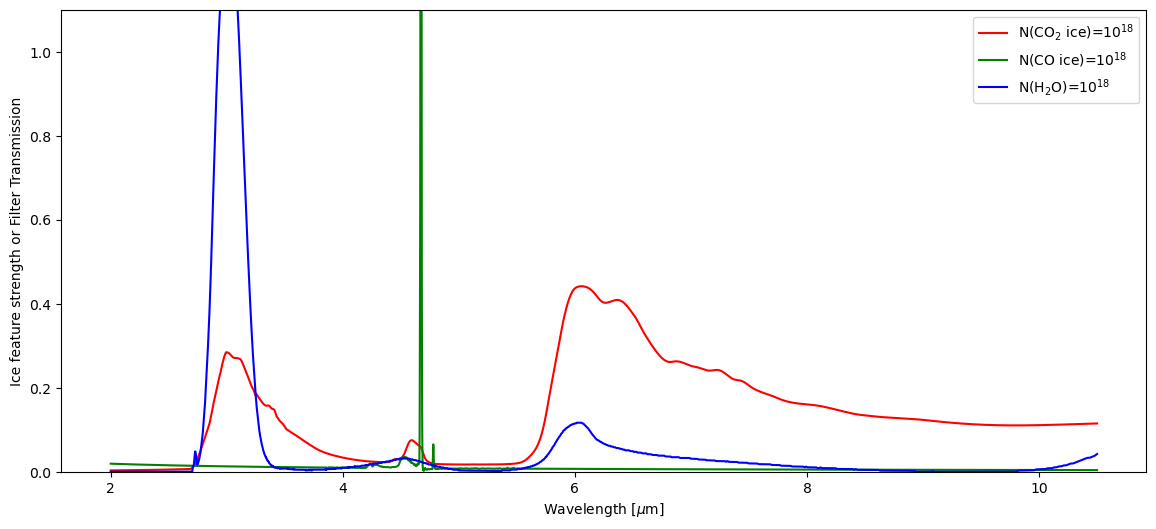

In [ ]:
fig = plt.figure(figsize=(14, 6))
xarr = np.linspace(2.0, 10.5, int(5e4))*u.um

mol = load_molecule_ocdb('co2')
mod = absorbed_spectrum(1e18*u.cm**-2, mol, return_tau=True, xarr=xarr)
plt.plot(xarr, mod, color='r', label='N(CO$_2$ ice)=10$^{18}$')

#mol = load_molecule_ocdb('co')
optical_constants_cache_dir = '/red/adamginsburg/repos/icemodels/icemodels/data/'
baratta_co = read_ocdb_file(f'{optical_constants_cache_dir}/1_CO_(1)_12.5K_Baratta.txt')
#mod = absorbed_spectrum(1e18*u.cm**-2, mol, return_tau=True, xarr=xarr)
mod = absorbed_spectrum(1e18*u.cm**-2, baratta_co, return_tau=True, xarr=xarr)
plt.plot(xarr, mod, color='g', label='N(CO ice)=10$^{18}$')

#mol = load_molecule_ocdb('h2o:ch3oh:co:nh3.100:10:1:1.10k')
#mol = load_molecule_ocdb('h2o.10k')
h2o = read_ocdb_file(f'{optical_constants_cache_dir}/107_H2O (1)_10K_Hudgins.txt')
mod = absorbed_spectrum(1e18*u.cm**-2, h2o, return_tau=True, xarr=xarr)
plt.plot(xarr, mod, color='b', label='N(H$_2$O)=10$^{18}$')

#mol = load_molecule_ocdb('ch3oh.10k')
#mod = absorbed_spectrum(1e18*u.cm**-2, mol, return_tau=True, xarr=xarr)
#plt.plot(xarr, mod, color='m', label='N(CH$_3$OH)=10$^{18}$')

plt.ylim(0,1.1)
plt.xlabel(f"Wavelength [$\\mu$m]")
plt.ylabel("Ice feature strength or Filter Transmission")
plt.legend()
# 3.6 - 5.8, would water ice affect these at all? 
# proof of concept finesst proposal 
# molecular hydrogen! 

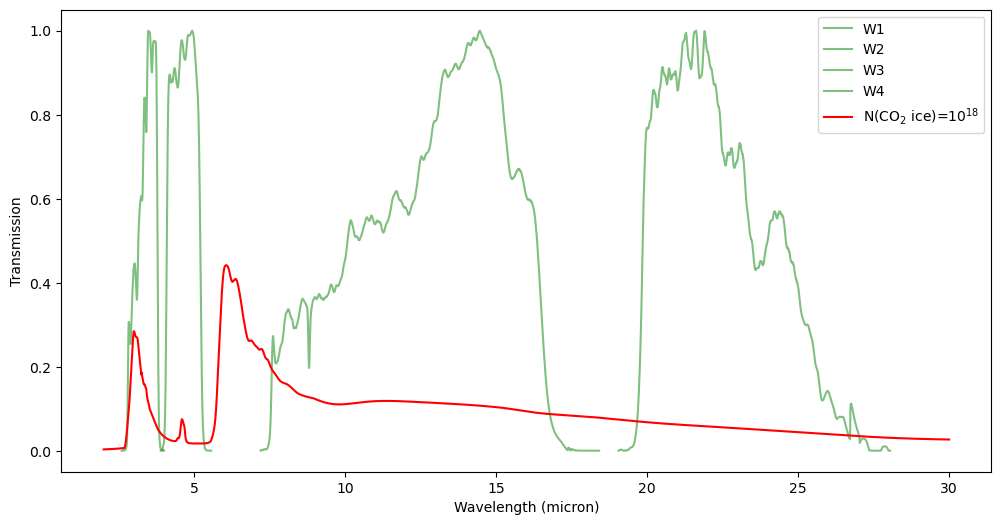

In [ ]:
fig = plt.figure(figsize=(12, 6))

for filt, tbl in wavelength_tables_wise.items():
    xarr = tbl['Wavelength'].quantity.to(u.micron)
    plt.plot(xarr, tbl['Transmission']/tbl['Transmission'].max(), color='g', alpha=0.5, label=filt)

xarr = np.linspace(2.0, 30, int(5e4))*u.um
mol = load_molecule_ocdb('co2')
mod = absorbed_spectrum(1e18*u.cm**-2, mol, return_tau=True, xarr=xarr)
plt.plot(xarr, mod, color='r', label='N(CO$_2$ ice)=10$^{18}$')

plt.xlabel('Wavelength (micron)')
plt.ylabel('Transmission')
plt.legend()